# House Price Leaderboard 정복하기🐱‍🏍

## 1. Loading and Exploring Data

### 1.1 Loading libraries required and reading the data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(test_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [3]:
# 데이터 불러오기
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print(train.shape, test.shape)

(15035, 21) (6468, 20)


### 1.2 Data size and structure

데이터의 변수명과 그 의미는 다음과 같다.

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
train.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

# 2. Exploring some of the most important variables

## 2.1 The response variable; price

가격 변수의 분포가 왼쪽으로 치우쳐 있는 것으로 보아 고가의 주택을 살 수 있는 사람이 많지 않다는 것을 알 수 있다. 한 쪽으로 치우친 분포는 모델이 결과를 예측하는데 영향을 미치기 때문에 scaling 처리를 해준다.

In [7]:
y = train['price']
del train['price']

<AxesSubplot:xlabel='price', ylabel='Density'>

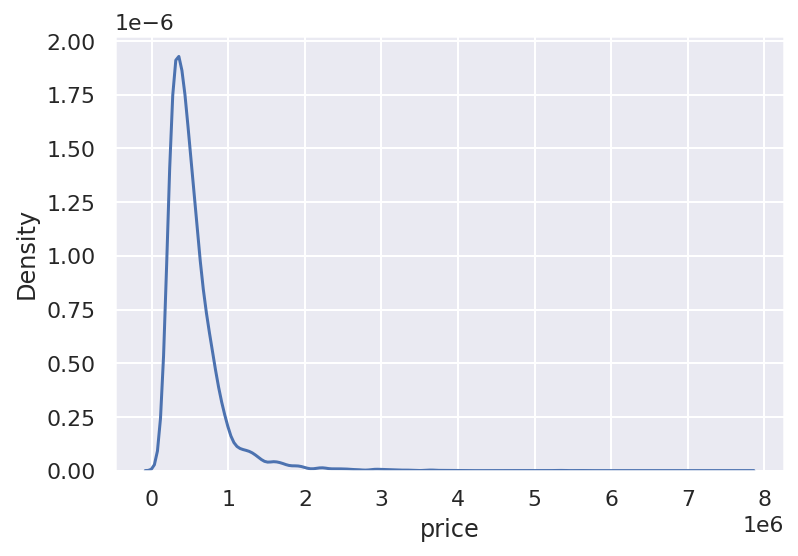

In [8]:
sns.kdeplot(y)

In [9]:
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

Skewness: 4.290252
Kurtosis: 40.154919


- 왜도(skewness): 오른쪽 꼬리가 길수록 값이 더 커진다.<br>
- 첨도(kurtosis / kurtosis) : 첨도 값 (K)이 3에 가까울 경우, 정규 분포에 가깝다. (K <3), 분포가 정규 분포보다 더 평탄하다. 첨도가 3보다 큰 경우 (K> 3), 분포가보다 뾰족한 분포로 판단 가능.

<AxesSubplot:xlabel='price', ylabel='Density'>

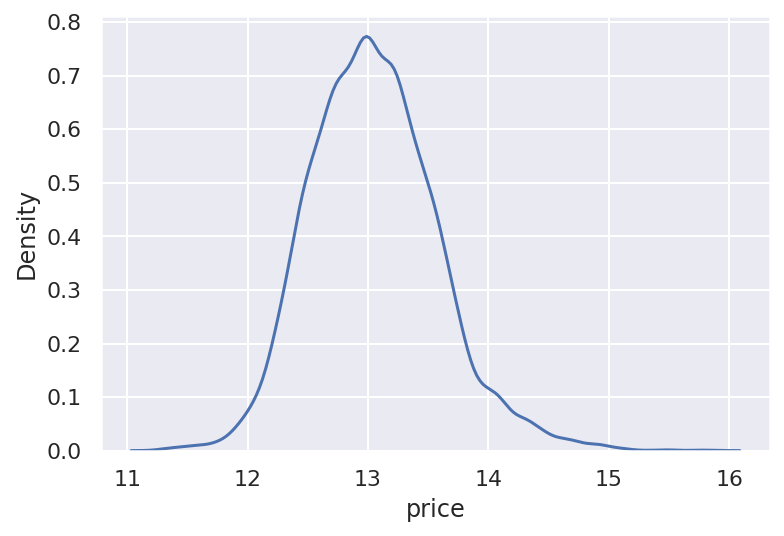

In [10]:
log_y = np.log1p(y)
sns.kdeplot(log_y)

## 2.2 The most important numeric predictors

__id, date 변수 정리__<br>
id 변수는 모델 예측과 상관 없는 변수이므로 제거한다.<br>
date 변수는, 연월만 고려하는 범주형 변수로 만들어준다.

In [11]:
del train['id'] # DataFrame.drop
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(str)
del test['id']
test['date'] = test['date'].apply(lambda x : str(x[:6])).astype(str)

### 2.2.1 Correlations with price

5개의 변수(bathrooms, sqft_living, grade, sqft_above, sqft_living15)가 price와의 양의 상관관계가 0.5 이상이다.<br>
또, 변수간의 상관도가 높은 다중공선성의 문제를 확인할 수 있다. 특히, sqrt_living과 sqft_above 사이의 상관관계(0.88)는 매우 높고, 둘 다 price와 0.5 이상의 상관관계를 가지고 있다.

> __다중공선성(Multicollinearity)__<br>
통계학의 회귀분석에서 독립변수들 간에 강한 상관관계가 나타나는 문제이다.
회귀분석의 전제 가정인 독립변수들 간에 상관관계가 높으면 안된다는 조건을 위배하며,
회귀계수가 해당 변수의 종속변수에 미치는 영향력을 올바로 설명하지 못하게 된다.

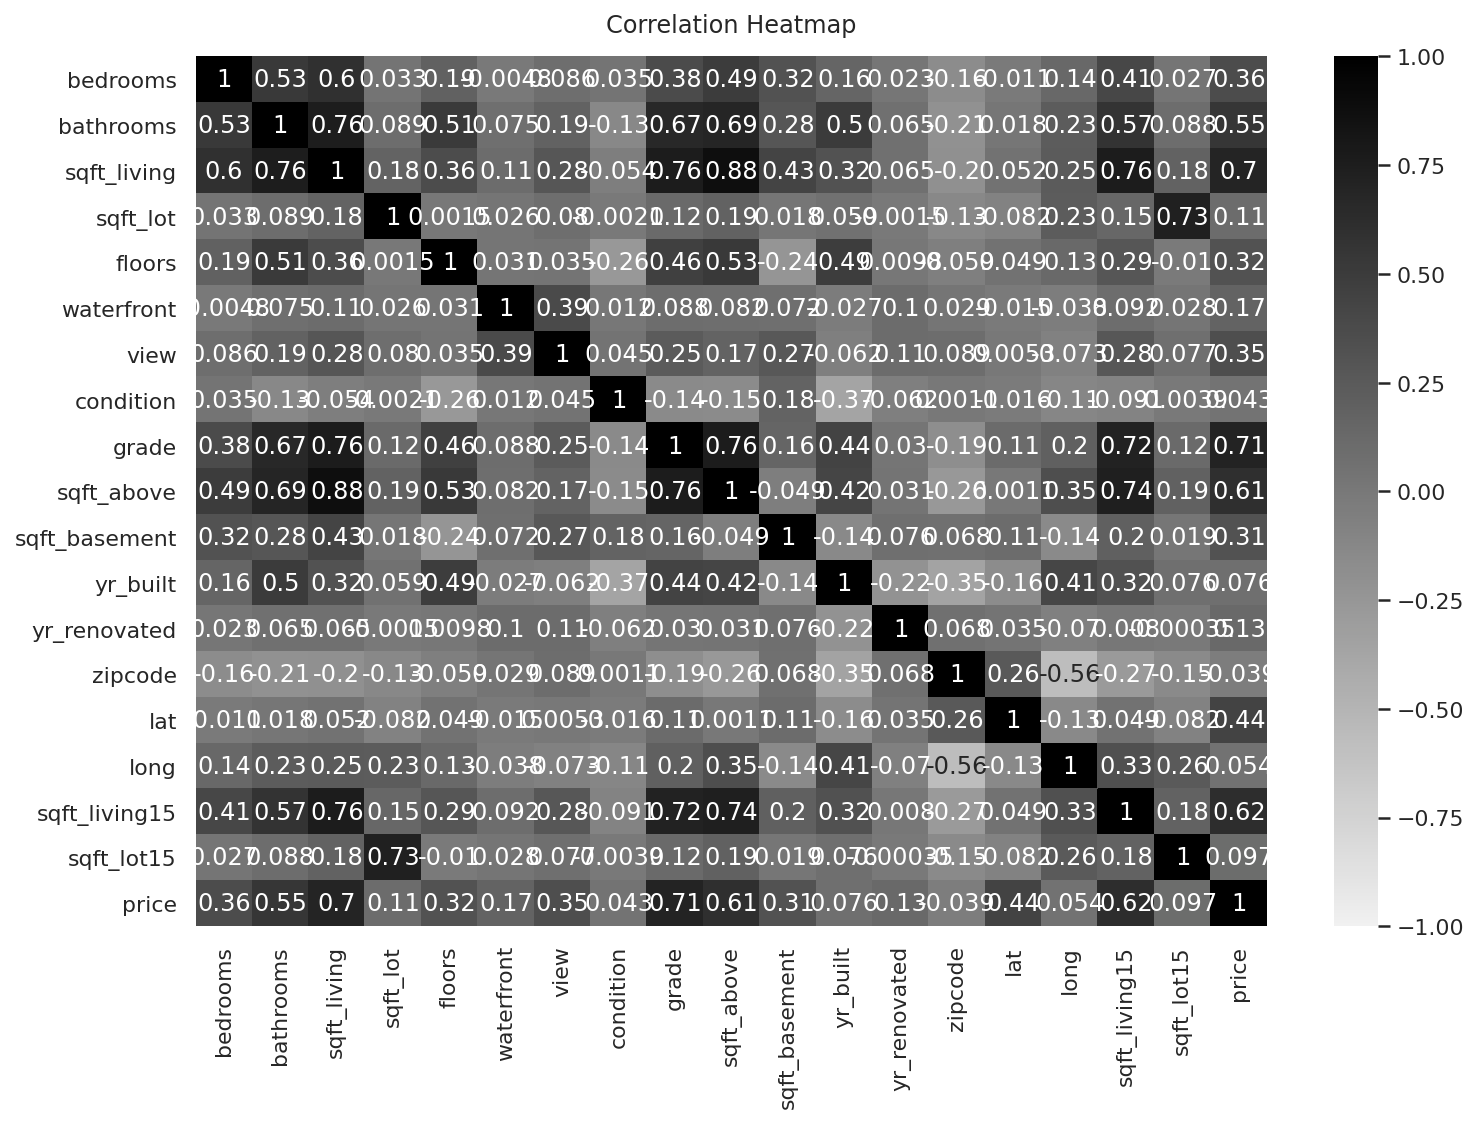

In [12]:
# log y와 변수들 간의 상관관계
y = np.log1p(y)
train_with_logprice = pd.concat((train, y), axis=1)

plt.figure(figsize=(12, 8))
cmap = sns.light_palette("black", as_cmap=True)
heatmap = sns.heatmap(train_with_logprice.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

### 2.2.2 sqft_living / sqft_living15

- sqft_living : 주거 공간의 평방 피트
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

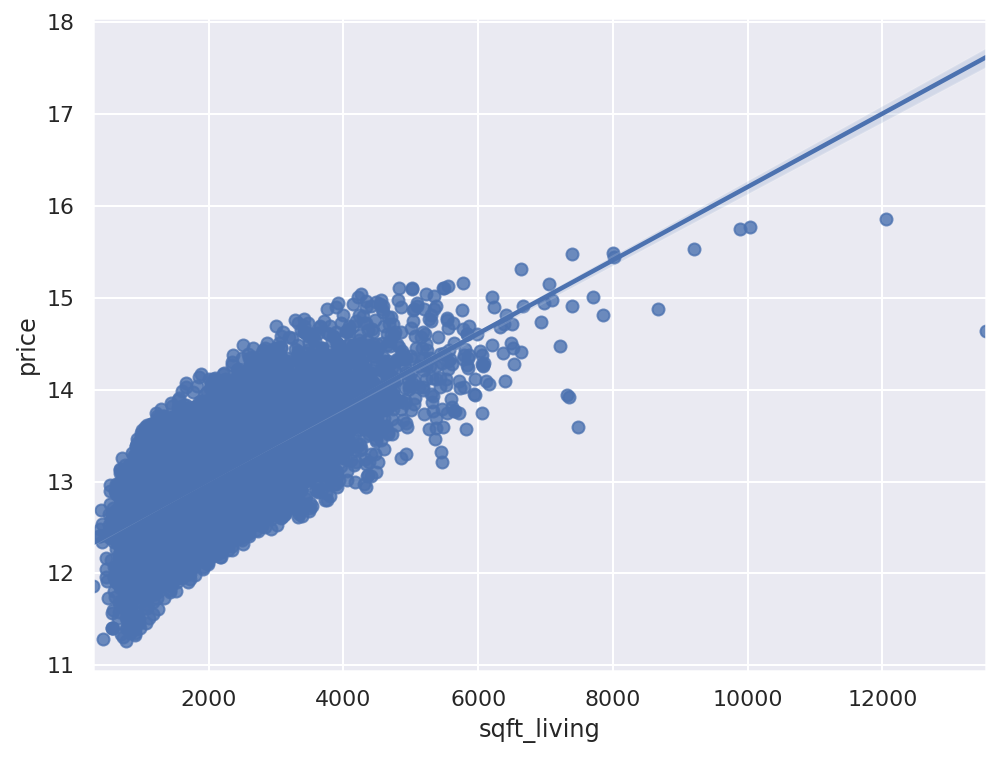

In [13]:
data = pd.concat([y, train['sqft_living']], axis=1)
plt.figure(figsize=(8, 6))
sns.regplot(x='sqft_living', y="price", data=data)

주거 공간의 평방 피트와 주택가격의 관계는 선형성을 띄지만, sqrt_living이 14000정도인데 가격이 14~15사이에 있는 특이값이 보인다. 나중에 살펴보고 처리 여부를 정해야 겠다.

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

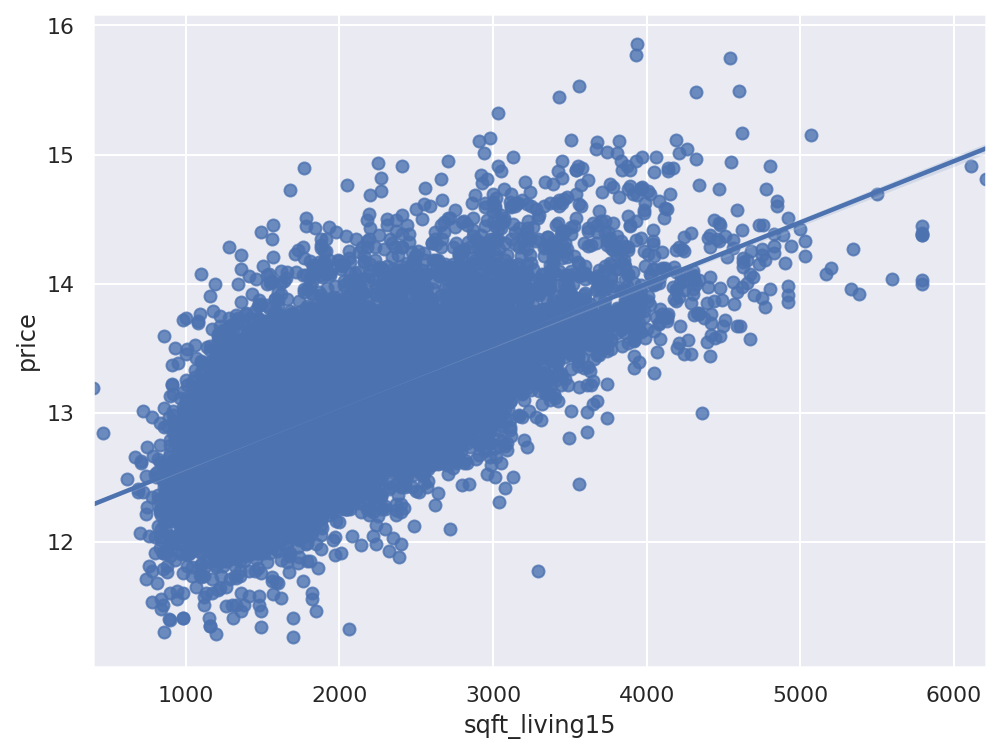

In [14]:
data = pd.concat([y, train['sqft_living15']], axis=1)
plt.figure(figsize=(8, 6))
sns.regplot(x='sqft_living15', y="price", data=data)

sqft_living15은 sqft_living에 비해 가격의 분산이 크며, 평방 피트의 분산은 비교적 작다.

### 2.2.2 grade

- grade : King County grading 시스템 기준으로 매긴 집의 등급

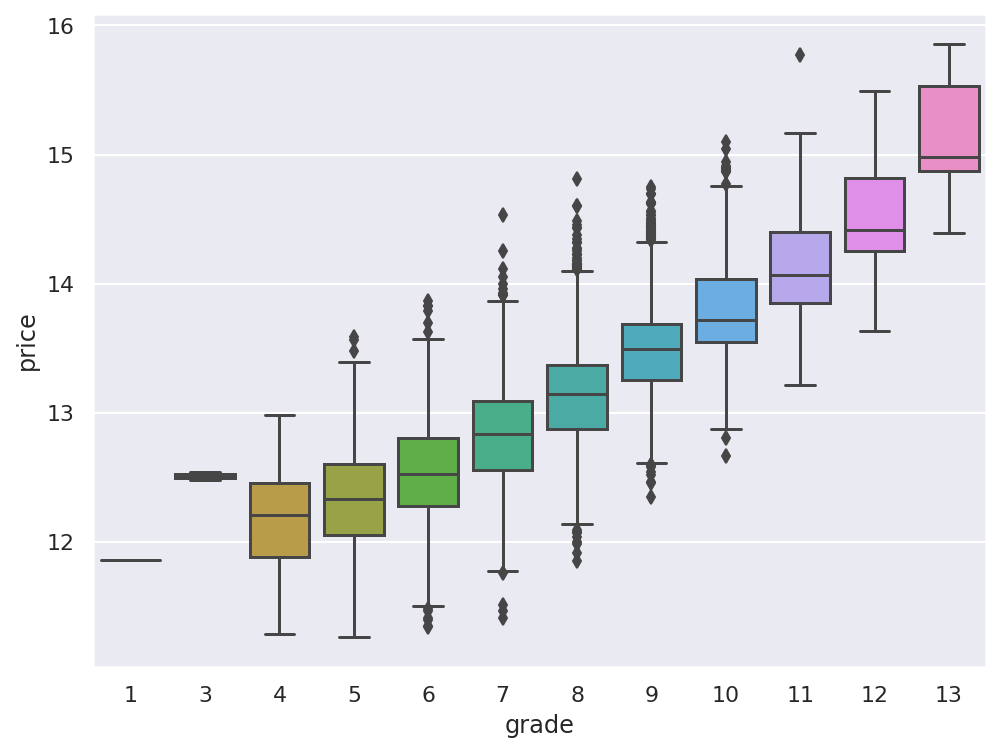

In [15]:
data = pd.concat([y, train['grade']], axis=1)
plt.figure(figsize=(8, 6))
sns.boxplot(x='grade', y="price", data=data)
plt.show()

등급은 주택 가격과 약 0.7정도의 높은 양의 상관성을 가지므로, 등급이 높을 수록 주택 가격도 높아지는 경향을 보인다.

### 2.2.3 sqft_above

- sqft_above : 지하실을 제외한 평방 피트

<AxesSubplot:xlabel='sqft_above', ylabel='price'>

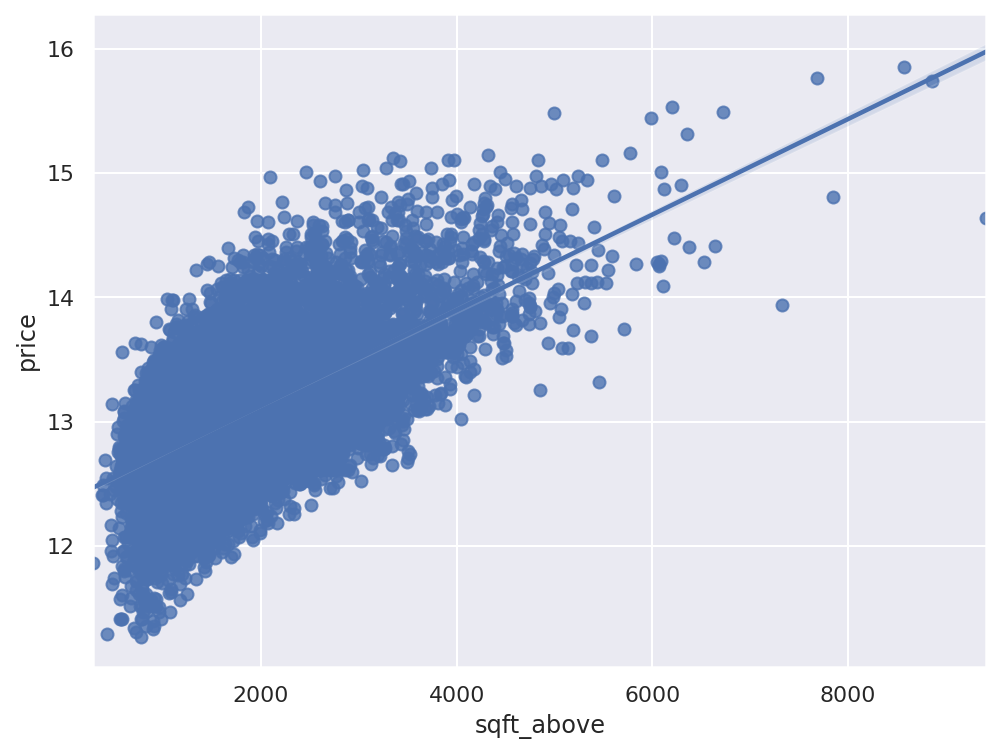

In [16]:
data = pd.concat([y, train['sqft_above']], axis=1)
plt.figure(figsize=(8, 6))
sns.regplot(x='sqft_above', y="price", data=data)

### 2.2.4 bathrooms

- bathrooms : 침실당 화장실 개수

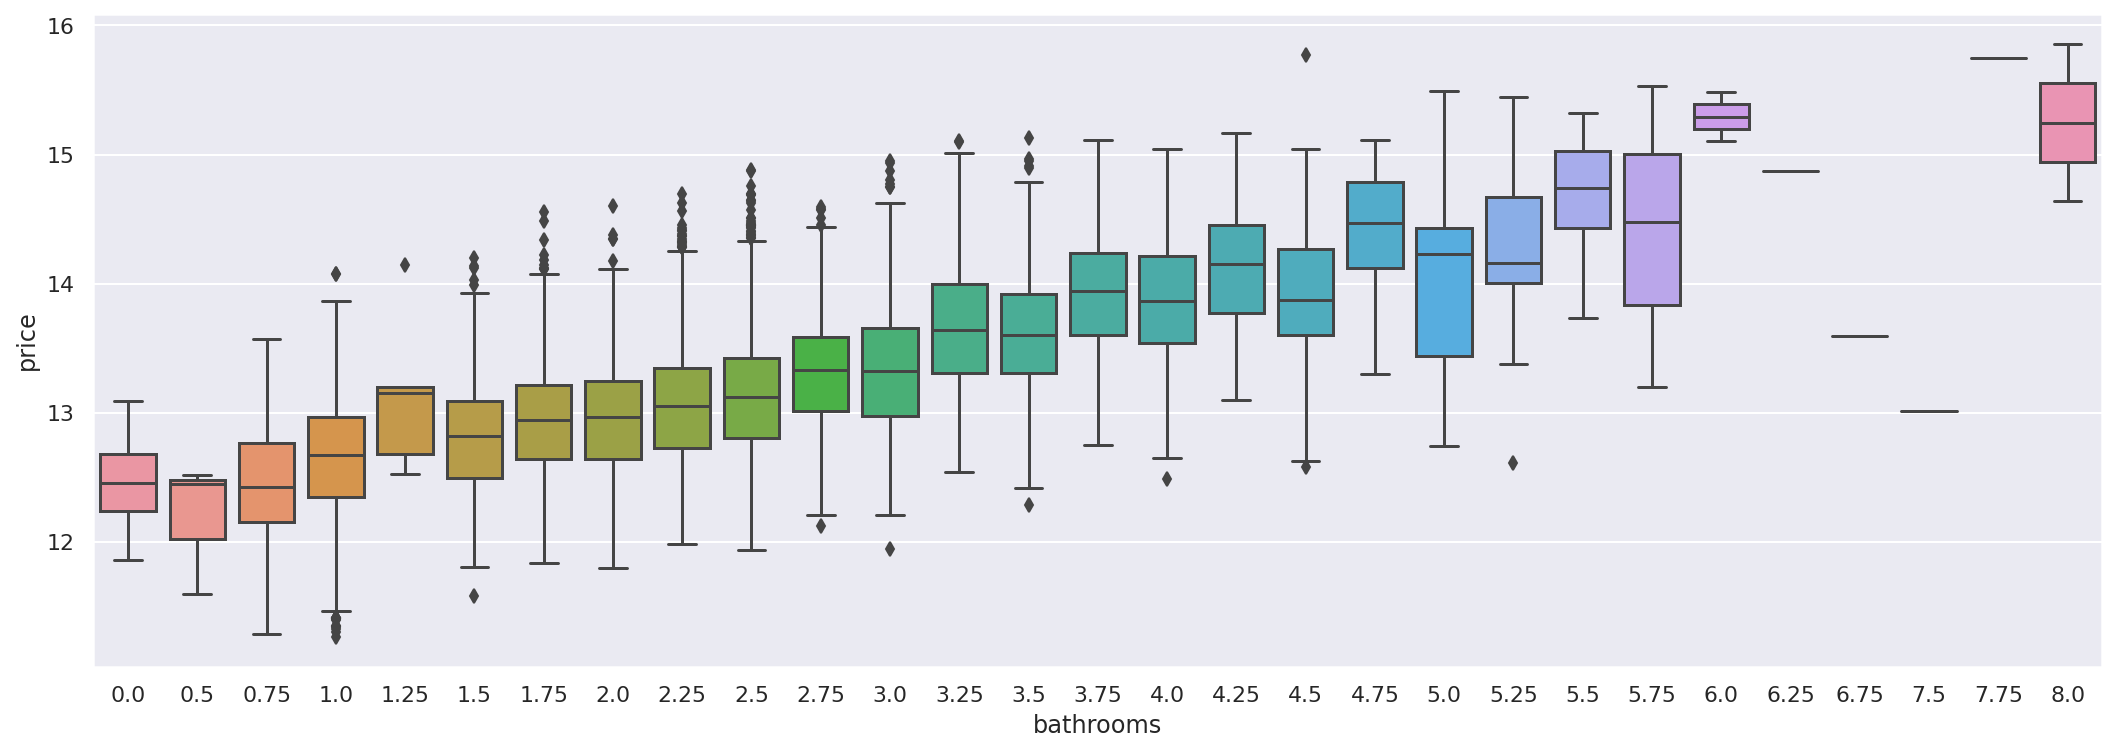

In [17]:
data = pd.concat([y, train['bathrooms']], axis=1)
plt.figure(figsize=(18, 6))
sns.boxplot(x='bathrooms', y="price", data=data)
plt.show()

화장실 개수가 많다는 것은 그만큼 방의 개수가 많다는 것이고, 집의 크기가 크다고 해석할 수 있을 것 같다. 그러므로 bathroom의 수가 많을 수록 가격이 올라가는 경향을 보인다. 6.25, 6.75, 7.5개의 가격 처럼 예외인 경우도 존재한다.

## 3. Data Preprocessing

## 3.1 Missing Data
데이터에 결측치가 있는지 확인한다.

<AxesSubplot:>

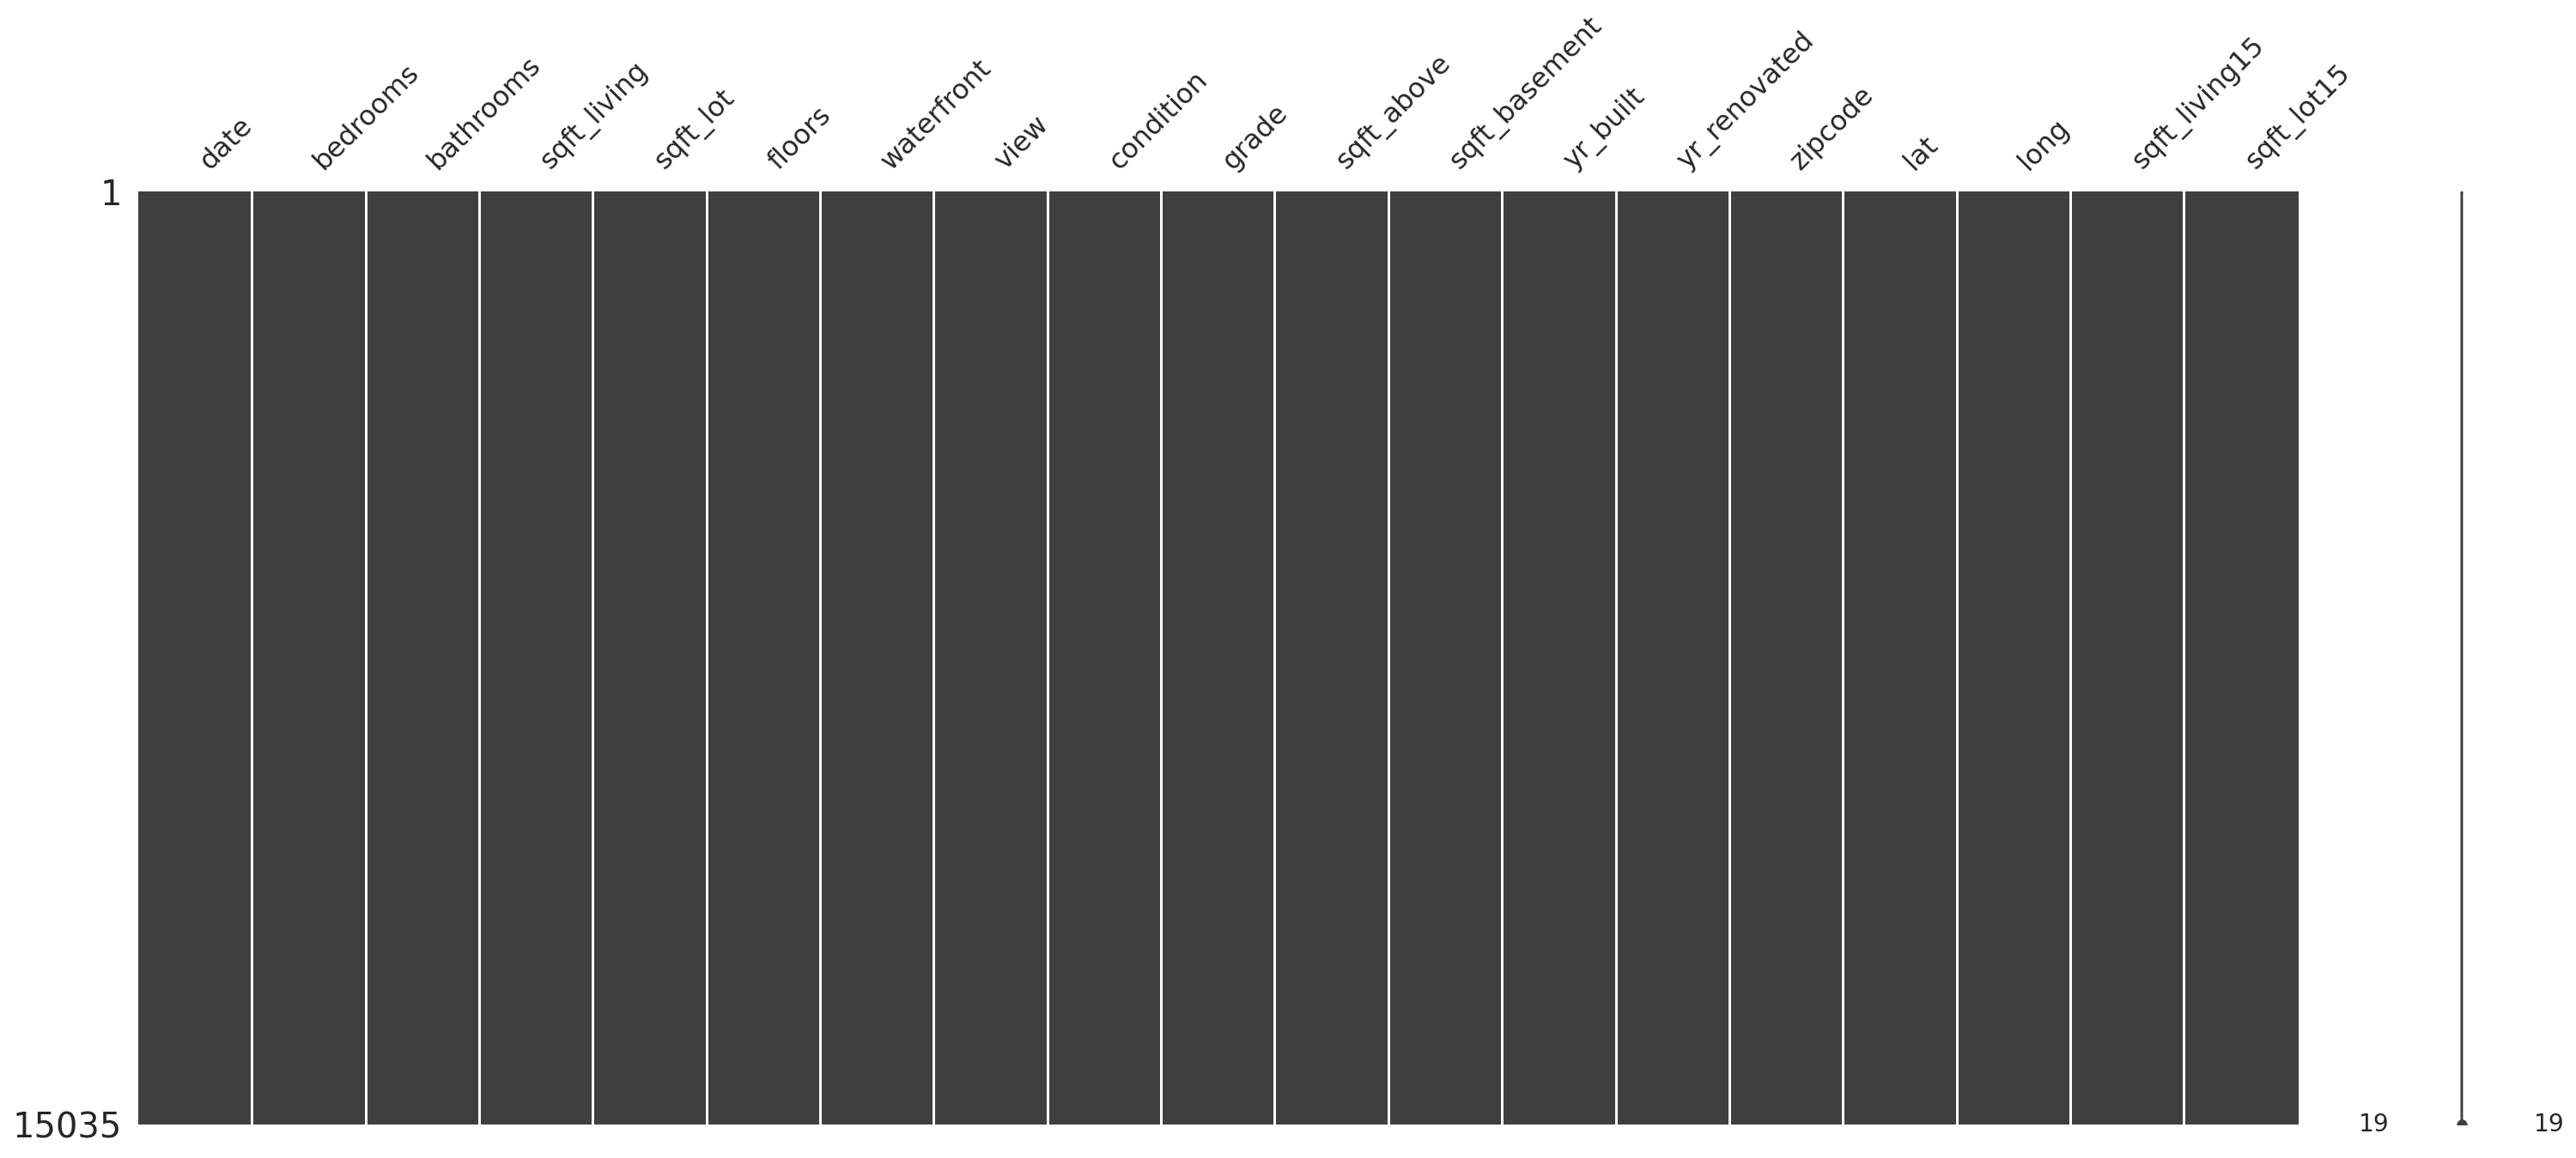

In [18]:
msno.matrix(train)

In [19]:
for column in train.columns:
    print('{} : {}'.format(column, sum(train[column].isnull()))) # df.isnull() 사용해 결측치 파악

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


## 3.2 Skewness and normalizing of the numeric predictors

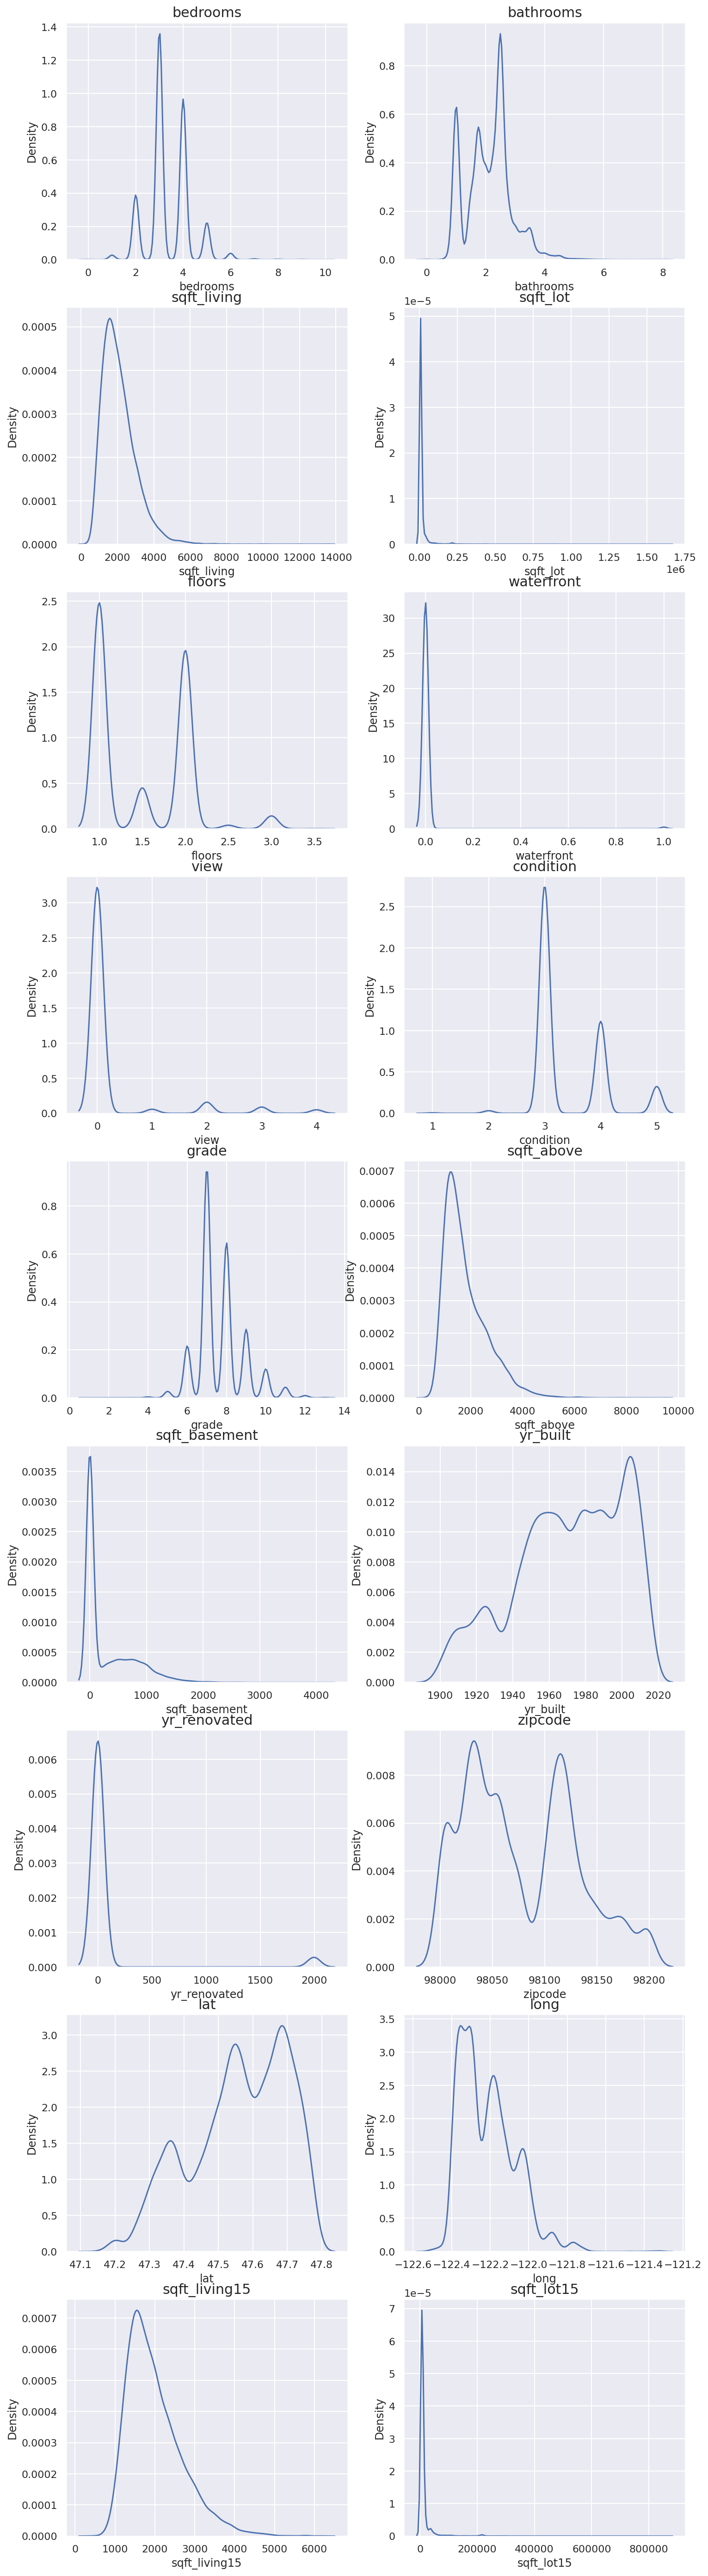

In [20]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [21]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

for column in skew_columns:
    train[column] = np.log1p(train[column].values)
    test[column] = np.log1p(test[column].values)

## 4. Feature engineering

In [22]:
for df in [train,test]:
    # 전체 방 갯수
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 부지에서 주거공간의 비율
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    # 전체 면적
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 전체 면적 대비 주거공간의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    # 전체 면적 대비 주거공간의 비율 (15년 기준)
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [23]:
# 평당 가격
train['per_price'] = y/train['sqft_total_size']
test['per_price'] = y/train['sqft_total_size']
# 주택 우편번호 기준으로 평당 가격의 평균과 분산 구하기
zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
# train, test에 위에서 구한 가격 적용
train = pd.merge(train,zipcode_price,how='left',on='zipcode')
test = pd.merge(test,zipcode_price,how='left',on='zipcode')

# 우편번호 기준으로 grouping 된 평당 가격의 평균과 분산 feature로 추가
for df in [train, test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

## 5. Select variables

In [24]:
len(train.columns)

28

In [25]:
len(test.columns)

28

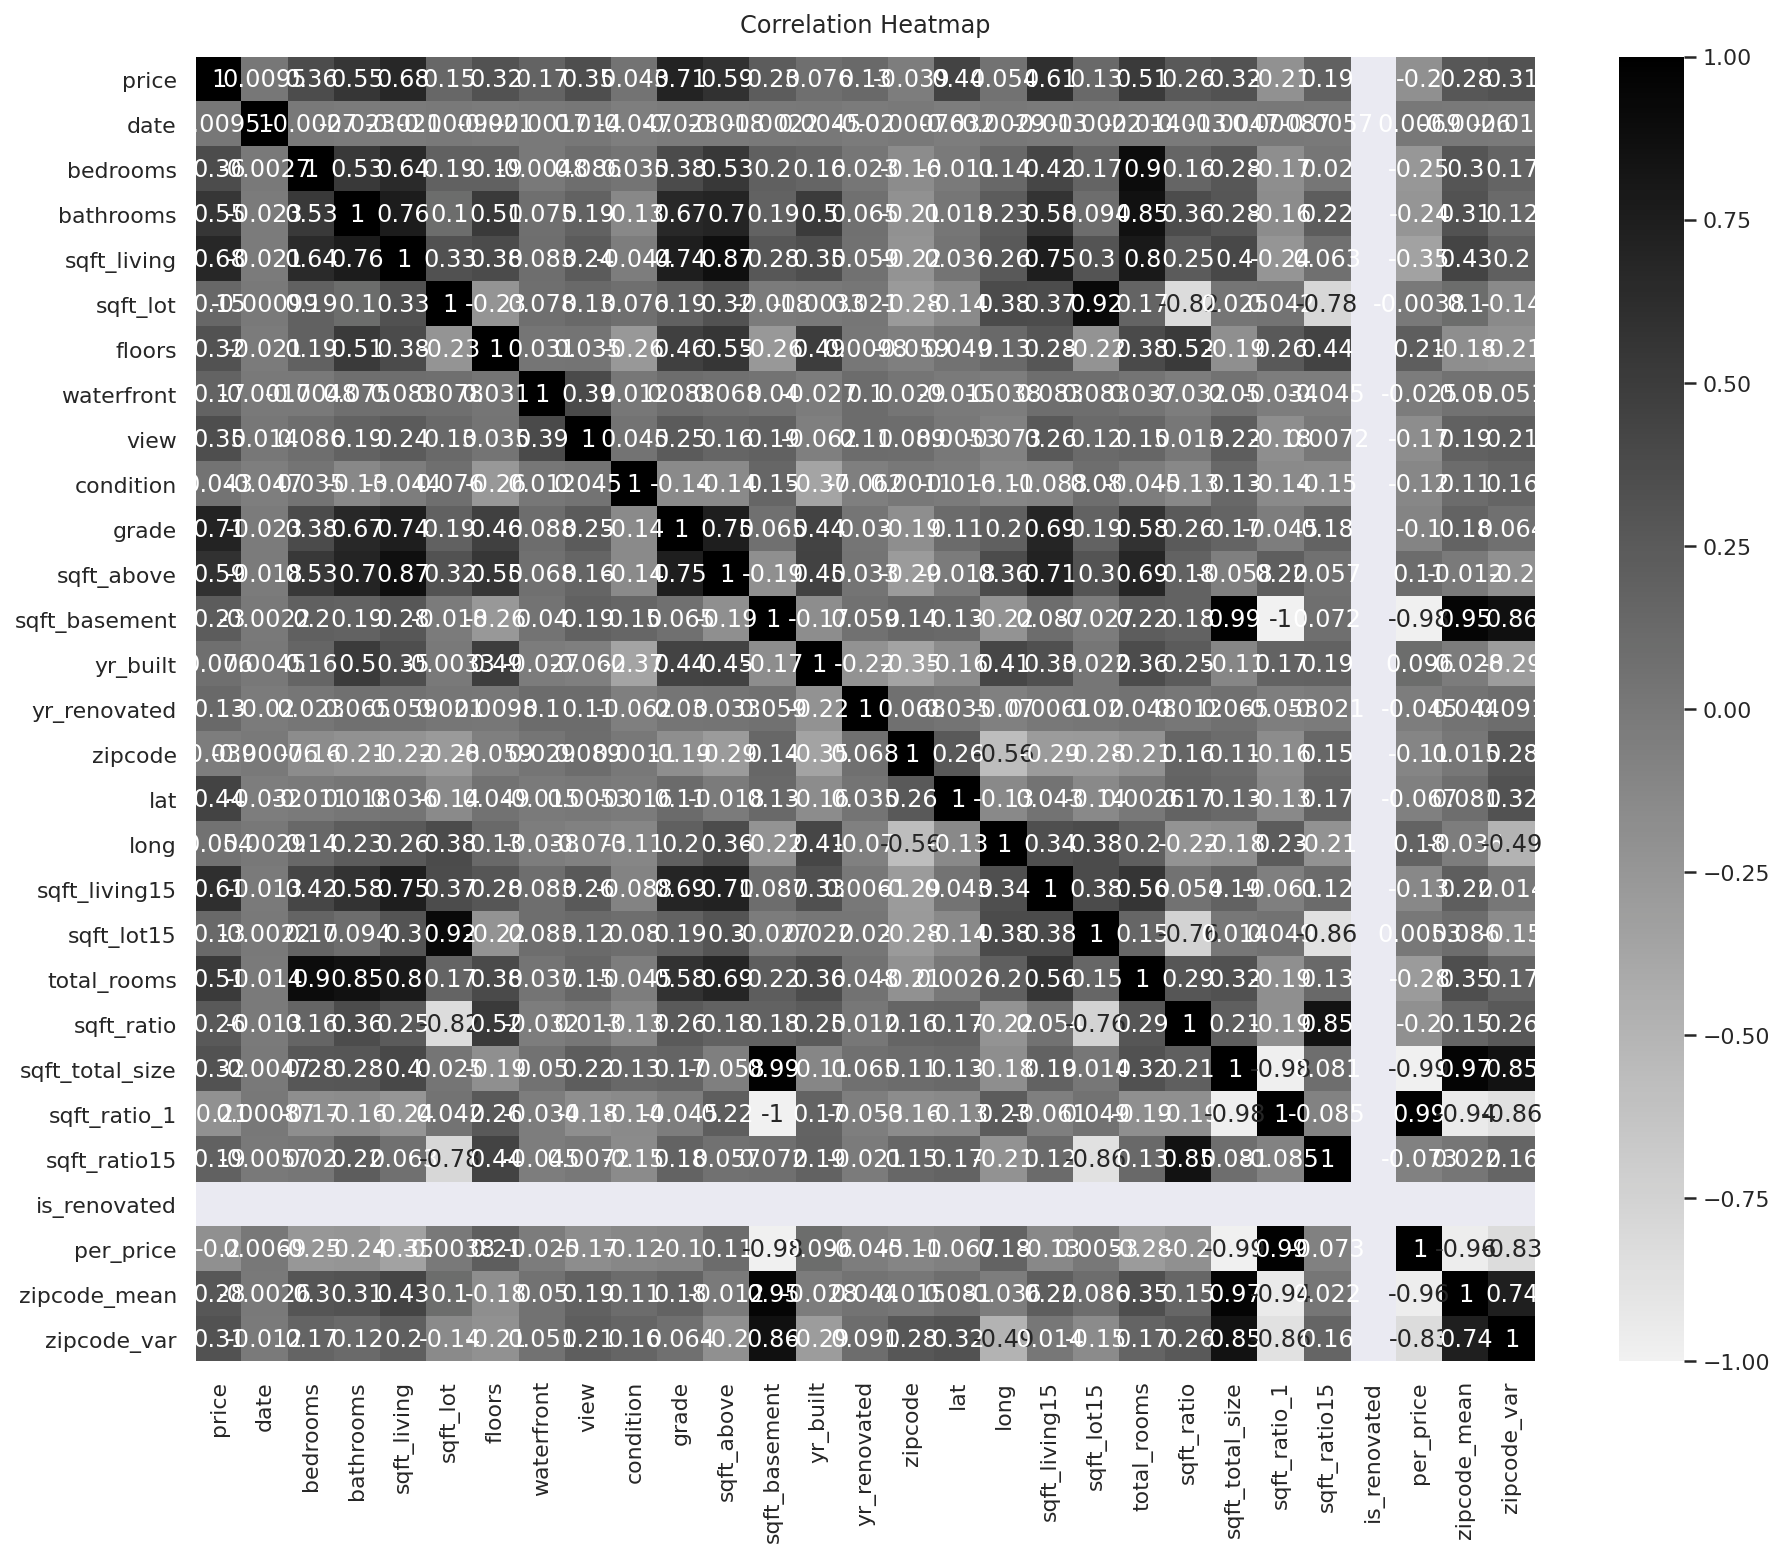

In [26]:
data = pd.concat([y, train], axis=1)
plt.figure(figsize=(15, 12))
cmap = sns.light_palette("black", as_cmap=True)
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

price를 제외한 변수들끼리의 상관관계가 높은것을 확인 할 수 있다.

In [27]:
x_formula = [c for c in train.columns]
x_formula = '+'.join(x_formula)
x_formula

'date+bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+grade+sqft_above+sqft_basement+yr_built+yr_renovated+zipcode+lat+long+sqft_living15+sqft_lot15+total_rooms+sqft_ratio+sqft_total_size+sqft_ratio_1+sqft_ratio15+is_renovated+per_price+zipcode_mean+zipcode_var'

In [28]:
import statsmodels.api as sm
data = pd.concat([y, train], axis=1)
tmp = sm.OLS.from_formula("price ~"+ x_formula, data=data)
print(tmp.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 1.589e+04
Date:                Tue, 10 Aug 2021   Prob (F-statistic):               0.00
Time:                        12:47:54   Log-Likelihood:                 13190.
No. Observations:               15035   AIC:                        -2.633e+04
Df Residuals:                   15009   BIC:                        -2.613e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.2296      2.113     

> [2] The smallest eigenvalue is 7.54e-18. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.

sm.OLS.from_formula()를 이용해 다중공선선이 있음을 확인하였다.사이킷런을 이용해 후진제거법 기반 방식인 RFE를 이용해 변수를 선택한다.
> __RFE (recursive feature elimination)__<br>
Backward 방식중 하나로, 모든 변수를 우선 다 포함시킨 후 반복해서 학습을 진행하면서 중요도가 낮은 변수를 하나씩 제거하는 방식

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import time
start= time.time()
    
# model = xgb.XGBRegressor(random_state=2021,objective='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
model = xgb.XGBRegressor(random_state=2021)
rfe = RFE(model, 8)
fit = rfe.fit(train, y)

print("Num Features:", fit.n_features_to_select)
print("Selected Features:", fit.support_)
print("Feature Ranking:", fit.ranking_)

end = time.time()
print(end-start)

In [ ]:
train.columns[fit.support_] # selected variables

In [33]:
selected_train = train[['grade', 'sqft_living15', 'total_rooms', 'sqft_ratio','sqft_total_size', 'sqft_ratio15', 'per_price', 'zipcode_mean']]

선택된 변수로 train data를 구성한다.

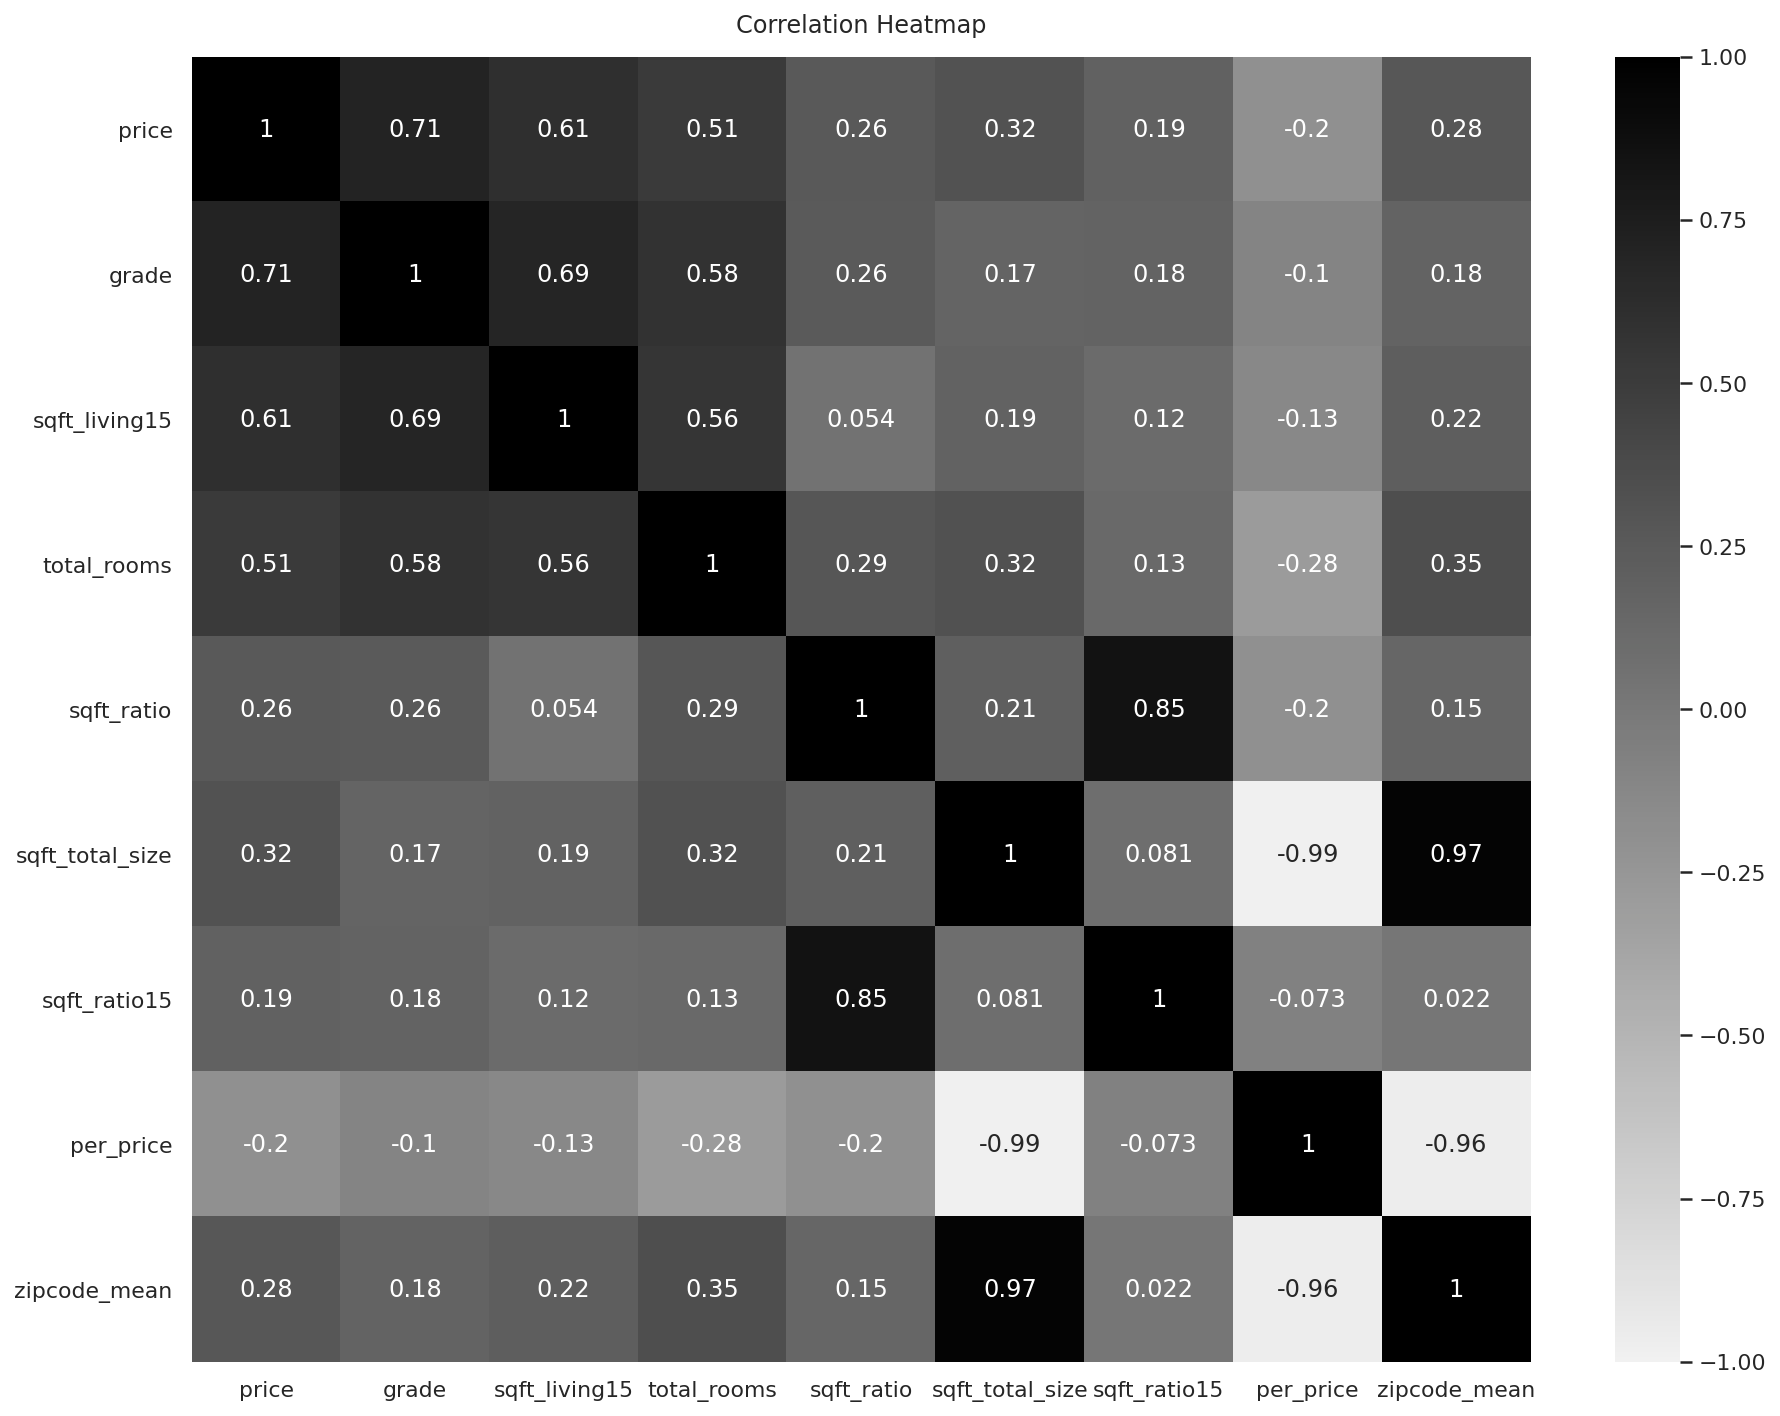

In [34]:
data = pd.concat([y, selected_train], axis=1)
plt.figure(figsize=(15, 12))
cmap = sns.light_palette("black", as_cmap=True)
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

여전히 다중공선성 문제 존재😰 

## 6. Modeling

### 6.1 모델 성능 비교

- gboost, xgboost, lightgbm, rdforest 모델의 RMSE와 Cross-Validation Score를 구해 어떤 모델을 사용하는 것이 좋은지 살펴보았다. lightgbm, xgboost가 성능이 좋은 편이다.
- 기본 Train Set이 학습된 결과보다 변수선택법으로 선택된 변수들로 학습된 결과가 더 좋았다.(gboost 제외)

- RMSE 계산
    - log scaling 된 y_test, y_pred 값을 exp를 사용해 원래대로 만들어준다.
    - np.sqrt(mean_squared_error())

In [35]:
# RMSE 계산 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    # y_test, y_pred는 log scaling된 값이므로 exp를 사용해 원래대로 돌려준다

In [39]:
# 모델 인스턴스 생성
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [40]:
# 각 모델의 RMSE 점수를 구하는 함수
def get_scores(models, train, y):
    
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터 셋 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [41]:
score_df = get_scores(models, train, y)
score_df

,RMSE
GradientBoostingRegressor,100512.332885
RandomForestRegressor,92949.569344
LGBMRegressor,70513.649475
XGBRegressor,63757.581434


In [47]:
# cross-validation
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train.values, y)), 
                                             kf=kfold))

In [48]:
get_cv_score(models)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
score_train = get_scores(models, train, y)
score_selected_train = get_scores(models, selected_train, y)

print(score_train)
print(score_selected_train)

In [ ]:
cv_score_train = get_cv_score(models, train)
cv_score_selected_train = get_cv_score(models, selected_train)

print(cv_score_train)
print(cv_score_selected_train)

GradientBoostingRegressor를 제외하고는 selected_train이 더 좋은 성능을 보인다.

## 7. Grid Search

1. GridSearchCV 모델로 `model`을 초기화.
2. 모델을 fitting 한다.
3. params, score에 각 조합에 대한 결과를 저장.
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환.

> __그리드 탐색__<br>
: 사람이 먼저 탐색할 하이퍼파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색한다. 탐색 공간이 제한적이다.

> __랜덤 탐색__<br>
:사람이 탐색할 하이퍼 파라미터의 공간만 정해주고, 그 안에서 램점으로 조합을 선택해서 탐색하는 방법이다. (비교적) 탐색 공간이 넓다

XGBoost는 시간이 너무 오래 걸려,좋은 결과가 나왔던 LightGBM의  하이퍼 파라미터 조합를 찾는다.

In [ ]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV로 모델 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',cv=5, verbose=1, n_jobs=5)
    # 모델 fitting
    grid_model.fit(train, y)
    
    # params, score에 각 조합에 대한 결과를 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # DataFrame에 점수 저장
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 추가 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score']) # Root Mean Squared Log Error 
    results.sort_values(by=['RMSLE']) # 내림차순으로 정렬
    
    return results

In [ ]:
# 후보 파라미터 선정
param_grid = {
    'n_estimators': [450, 500, 550, 600, 650, 700],
    'max_depth': [11, 13, 15, 17, 19],
    'num_leaves': [15, 31],
    'learning_rate': [0.02, 0.05 , 0.1, 0.2]
}

# Grid Search CV 객체 정보 입력
result = my_GridSearch(lightgbm, train[train_columns], y, param_grid, verbose=2, n_jobs=5)

In [ ]:
result.sort_values(by=['RMSLE'])

가장 좋은 조합은 learning rate=0.05, max_depth=19, n_estimators= 650, num_leaves=31 이다.

## 8. Submission


1. 최적의 조합으로 모델을 구성하고, 모델을  `train`, `y`로 학습시킨다.
2. `test`에 대해 예측한다.
3. 예측값을 `np.expm1`으로 변환하고, `csv` 파일을 저장한다.

In [ ]:
def save_submission(model, train, y, test, model_name, rmsle):
    
    # 모델 구성
    model = LGBMRegressor(learning_rate=0.05, max_depth=19, n_estimators= 650, num_leaves=31, random_state=2021)
    
    # 모델 훈련
    model.fit(train, y)
    
    # 예측
    prediction = model.predict(test)
    
    # 예측값 원래대로 변환
    prediction = np.expm1(prediction)
    
    # 제출파일 불러오기
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    # 예측한 값 덮어씌우기
    submission['price'] = prediction
    
    # csv로 저장
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(lightgbm, train, y, test, 'lgbm', rmsle='0.160779')

In [ ]:
selected_test = test[['grade', 'sqft_living15', 'total_rooms', 'sqft_ratio','sqft_total_size', 'sqft_ratio15', 'per_price', 'zipcode_mean']]
save_submission(xgb_model, train, y, test, 'xgb', rmsle='0.213922')

***

## 프로젝트 정리

- 아래의 kaggle code 들을 참고하여 프로젝트를 진행하였다.
    - https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda#loading-and-exploring-data
    - https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12
- base line의 결과가 11만정도였는데 EDA를 통한 Feature Engineering 이후 점수가 80만, 60만 등 악화되었다.. 아직 문제를 못찾은 상태.. 
    - (https://8888-wp32m52fylsw7te7mcrzj14ww.e.aiffel-3.ainetwork.ai/notebooks/aiffel/exploration/exploration06_predict_house_pricie_upgrade.ipynb)
- Feature Engineering 하면서 늘어난 변수들은 서로의 조합으로 만들어진게 많다보니 다중공선성의 문제가 있었다.
- 다중공선성은 sm.OLS.from_formula()를 이용해 확인할 수 있었다. 
> [2] The smallest eigenvalue is 7.54e-18. This might indicate that there are strong multicollinearity problems or that the design matrix is singular.
-  결과에 설명력을 높이기 위해 중요한 변수들을 고르는 변수선택작업을 진행하였다. (여전히 변수끼리의 다중공선성은 존재)
- sklearn의 변수선택 모듈 중 하나인 RFE (recursive feature elimination)를 통해 주요한 변수들을 선택하여 학습하였다.
- 모델의 성능은 gboost, xgboost, light gbm, random forest 모델의 RMSE 구해 어떤 모델을 사용하는 것이 좋은지 살펴보았는데, 선택된 변수 8개로만 학습된 결과가 더 좋았다. (gboost 제외)
- Cross-Validation Score를 구해 어떤 모델을 사용하는 것이 좋은지 살펴보았다.
    - lightgbm, xgboost가 성능이 좋은 편
    - cross validation 하면서 xgboost에 key error 발생, 내용은 base_score에서 문제가 생겼다는 내용으로 검색을 해봐도 근본적인 해결방법은 찾지 못했고 sklearn 자체에 에러로 print만 하지 않으면 모델은 돌아간다고 한다. 그래도 sklearn 버전을 바꿨을 때 해결되었다는 내용이 있어 최신버전으로 업그레이드 진행 -->  미해결😭
-  Grid Search를 이용해 최적의 하이퍼파라미터를 찾았다. xgboost는 시간이 너무 오래 걸려 진행이 어려워, lgbm으로 진행하였다.
- 점수를 높이기 위해 앙상블을 이용하였다. lgbm과 xgboost의 결과를 합쳐 진행하였다.

![score](https://8888-wp32m52fylsw7te7mcrzj14ww.e.aiffel-3.ainetwork.ai/files/aiffel/kaggle_kakr_housing/data/kgkr_107844.png)